# Modèle de réseau neuronale

C'est plus simple de faire le modèle sur le notebook pour pouvoir analyser chaque étape avec précision

In [12]:
#Imports

In [13]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import seaborn as sns #On ne sait jamais que ça serve
import pandas as pd #Même argument


In [14]:
#from alexnet_pytorch import AlexNet # ça fait planter matplotlib
#A_model = AlexNet.from_pretrained('alexnet', num_classes=10)

In [15]:
#Insert des données

In [16]:
#Idéalement, il faudrait ajouter les données batch par batch pour ne pas trop faire souffrir la ram

In [17]:
labels_csv = pd.read_csv('DATA\\labels.csv')

In [18]:
for line in labels_csv.values:
    label = line[0]
    name = line[1]
    #print(f"Le label est '{label}' et le nom de la vidéo : '{name}'")

In [19]:
X_link = []
y = []
for label,name in labels_csv.values:
    X_link.append(name)
    y.append(label)

In [20]:
#a_vid.get(cv2.CAP_PROP_POS_MSEC) #donne la position dans la vidéo en ms, on est à 25 fps donc chaque image est espacée de 40ms


### function: insert imgs/videos

In [21]:
def get_imgs_from_path(path,fps = -1):
    '''
    Retourne une liste d'images. La liste d'image a le nombre de fps voulu
    '''
    cap = cv2.VideoCapture(path)
    fps_actu = cap.get(cv2.CAP_PROP_FPS)
    if fps <= -1: fps = fps_actu #Je peux ne pas donner de fps et ça va prendre le nombre d'fps initial
    ecart_voulu = int(1000/fps)
    ecart_initial = int(1000/fps_actu)
    imgs = []
    
    
    while(cap.isOpened()):
        ret, frame = cap.read()

        if ret: #Sinon ça plante quand il n'y a plus d'images
            
            #Bonne couleur
            frame_RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            
            #Récupère seulement certaines images
            t_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
            modulo = t_ms % ecart_voulu
            if modulo < ecart_initial:
                #Isoler les images
                imgs.append(frame_RGB)
            
        else: #Va jusqu'au bout de la vidéo
            break
    else:
        print("Le fichier n'a pas pu être ouvert")
    cap.release()
    
    return imgs

In [263]:
def get_mov_imgs_from_path(path,fps = -1,color = 'gray'):
    '''
    Retourne une liste d'images. La liste d'image a le nombre de fps voulu
    reprend que le mouvement
    '''
    cap = cv2.VideoCapture(path)
    fps_actu = cap.get(cv2.CAP_PROP_FPS)
    print(f"Traitement de la video n° {path}",end="\r")
    if fps <= -1: fps = fps_actu #Je peux ne pas donner de fps et ça va prendre le nombre d'fps initial
    ecart_voulu = int(1000/fps)
    ecart_initial = int(1000/fps_actu)
    imgs = []
    
    ret, frame = cap.read()
    
    while(cap.isOpened()):
        prev = frame
        ret, frame = cap.read()

        if ret: #Sinon ça plante quand il n'y a plus d'images
            #Récupère seulement certaines images
            t_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
            modulo = t_ms % ecart_voulu
            if modulo < ecart_initial:
                #Isoler les images
                
                diff = cv2.absdiff(frame,prev)  
                if color == 'gray':
                    diff_gray = cv2.cvtColor(diff,cv2.COLOR_BGR2GRAY)
                elif color == 'rgb':
                    diff_gray = diff
                #Normalisation foireuse pour avoir une belle image
                max_ = np.max(diff_gray)
                ratio = 255.0 / max_
                diff_gray = diff_gray * ratio
                
                
                #_,diff_thresh = cv2.threshold(diff_gray,15,255,cv2.THRESH_BINARY)
                #diff_thresh, c'est juste le mouvement Ici on isole l'image en couleur
                #frame_rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
                #J'isole le mouvement de l'image initiale pour avoir une sortie en couleur
                #mov = cv2.bitwise_and(frame_rgb,frame_rgb,mask = diff_thresh)
                
                #On va travailler avec des images en nuance de gris, c'est bcp plus simple
                imgs.append(diff_gray)
            
        else: #Va jusqu'au bout de la vidéo
            break
    else:
        print("Le fichier n'a pas pu être ouvert")
    cap.release()
    
    return imgs

In [264]:
mov_imgs = get_mov_imgs_from_path('DATA\\Videos\\video_101.avi',-1)
#mov_imgs = resize_imgs(mov_imgs,(160,120))

(480, 640)


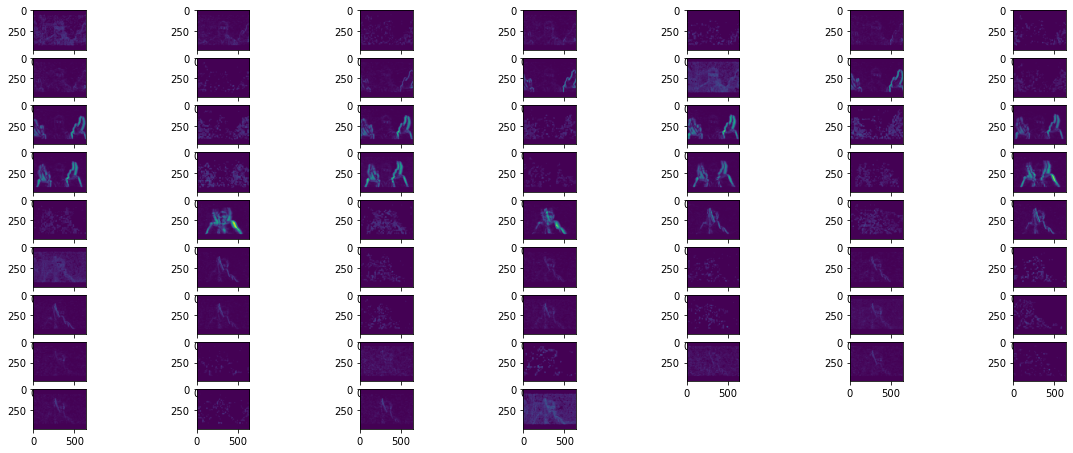

In [266]:
plt.figure(figsize=(20,60)) #(20,60) pour des images en (120,160). (20,180) pour des images en (480,640)
print(mov_imgs[1].shape)
columns = 7
for i, img in enumerate(mov_imgs):
    plt.subplot(int(len(img) / columns + 1), columns, i + 1)
    plt.imshow(img)

In [25]:
len(mov_imgs)

60

In [26]:
labels_file = pd.read_csv('DATA\\labels_list.csv')
labels = labels_file.values

In [27]:
print(len(labels))

13


In [28]:
label_num = 10
if (label_num >= len(labels)):
    label_num = 0
label = labels[label_num][0]
print(label)

Ouvrir un livre avec le poing ferme main D


### function: resize

In [29]:
def resize_imgs(imgs,nsize):
    '''
    Change la taille de l'image.
    Le premier élément de nsize est la longueur (width), le deuxième la hauteur (height)
    '''
   # new_imgs = []
  #  for img in imgs:
 #       new_imgs.append(cv2.resize(img, dsize=nsize, interpolation=cv2.INTER_CUBIC))
#    return new_imgs
    return [cv2.resize(img, dsize=nsize, interpolation=cv2.INTER_CUBIC) for img in imgs]

In [30]:
#plt.imshow(imgs[2])

In [31]:
def reduce_fps(imgs,ratio = 6):
    '''
    imgs est une liste d'images
    1/ratio est le nombre d'images qu'on garde
    '''
    new_imgs = []
    for i,img in enumerate(imgs):
        if i % ratio == 0:
            new_imgs.append(img)
    return new_imgs    

#### Test TfRecord

In [32]:
#from video2tfrecord import convert_videos_to_tfrecord

In [33]:
#convert_videos_to_tfrecord(source_path = "test_data\\Videos",destination_path = "test_data\\tfRecords",
#                            n_videos_in_record = 1,n_frames_per_video = "all",file_suffix = "*.avi",
#                          dense_optical_flow=True, width = 640, height=480,
#                              color_depth="uint8", video_filenames=None)
#Broken

## Real Insert

In [303]:
#Récupère toutes les vidéos, prend slmt z fps et les resize
import time
folder_path = 'Data\\Videos\\'
fps = 10
size = (160,120) # La shape initial est (480, 640, 3), Il faut inverser le sens de with et height.
#Size demi par rapport à initial
nb_images_max = 10 #Prend les x premières images

start = time.time()
X = []
for i,name in enumerate(X_link):
    file_path = folder_path + name
    imgs_of_video = get_mov_imgs_from_path(file_path,fps,'gray')
    resized_imgs = resize_imgs(imgs_of_video, size)
    X.append(resized_imgs)
    if i >= nb_images_max:
        break
end = time.time()
y = y[:len(X)]

print(f"ça a prit {end-start} secondes",end=" "*15)

ça a prit 1.8755943775177002 secondes               

In [304]:
print(f"Il y a {len(X)} vidéos et {len(y)} labels") #Petite vérification
print(X[0][0].shape)

Il y a 11 vidéos et 11 labels
(120, 160)


('Explosion avec les doigts ouverts', 'Explosion avec les doigts ouverts', 'Faire coucou', 'Explosion avec les doigts ouverts', 'Faire coucou', 'Prendre un element avec 2 doigts', 'Faire coucou', 'Explosion avec les doigts ouverts', 'Faire coucou', 'Prendre un element avec 2 doigts', 'Prendre un element avec 2 doigts')
3


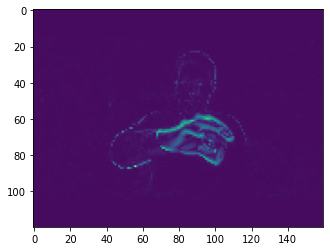

In [296]:
#Melanger les videos associés aux labels
import random
both = list(zip(X,y))
random.shuffle(both)
X,y = zip(*both)
print(y)
plt.imshow(X[-1][10])
nb_classes = len(set(y))
print(nb_classes)

In [270]:
#[f"{len(vid)} , {e}" for e,vid in enumerate(X)] # Toutes les vidéos n'ont pas le même nombre de frame


(120, 160)
label = Explosion avec les doigts ouverts


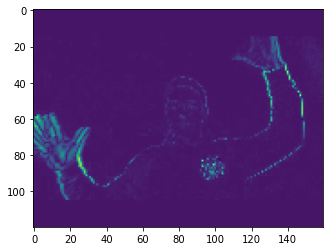

In [289]:
num_vid = 6
plt.imshow(X[num_vid][11])
print(X[num_vid][10].shape)
print(f"label = {y[num_vid]}")

C'est ok pour l'import des vidéos et le traitement de celles-ci
On prend un certain nombre de FPS, leur taille est réduite et elles sont mises dans une grande liste 
dont l'index correspond à l'index du label dans y

24


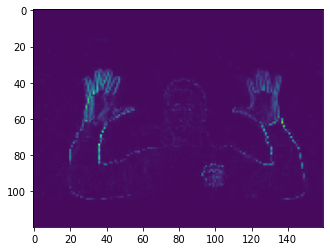

In [290]:
print(len(X[0]))
plt.imshow(X[5][20])

## Modele fabrication

In [291]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import  Dense, Conv3D, BatchNormalization,MaxPooling3D, Dropout, LSTM

In [444]:
sample_shape = (24,120,160,1) #width = 160, height = 120, nframes = 24, 3 channels si on est en RGB (si on est en gris on sait pas)
model = Sequential()
model.add(Conv3D(32, strides =(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape,data_format='channels_first'))
#model.add(Conv3D(32, strides =(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape,data_format='channels_last'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization(center=True, scale=True))
model.add(Conv3D(32, strides=(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization(center=True, scale=True))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(Dropout(0.2))

model.add(Conv3D(64, strides=(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization(center=True, scale=True))
model.add(Conv3D(64, strides=(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization(center=True, scale=True))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(Dropout(0.2))

model.add(Conv3D(64, strides=(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization(center=True, scale=True))
model.add(Conv3D(64, strides=(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization(center=True, scale=True))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(Dropout(0.2))

model.add(Conv3D(128, strides=(1,1,1), padding="same", kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization(center=True, scale=True))

#model.add(Dense(1, activation='relu', kernel_initializer='he_uniform'))
#model.add(MaxPooling3D(pool_size=(1, 3, 3)))
#model.add(layers.Reshape((128, 5120),input_shape = (1,128,4,5,256)))
#model.add(layers.Reshape((128, 640),input_shape = (1,128,4,5,32)))
model.add(layers.Reshape((1,640),input_shape = (1,4,5,32)))
#model.add(layers.Flatten())

#LSTM
#model.add(Embedding(num_distinct_words, embedding_output_dims, input_length=max_sequence_length))
model.add(LSTM(units = 128,activation="tanh", recurrent_activation="sigmoid",return_sequences = False))
#[None, 128, 4, 5, 256]


#softmax
model.add(Dense(11, activation='softmax'))

model.summary()


Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_375 (Conv3D)          (None, 32, 120, 160, 1)   20768     
_________________________________________________________________
dense_385 (Dense)            (None, 32, 120, 160, 256) 512       
_________________________________________________________________
batch_normalization_347 (Bat (None, 32, 120, 160, 256) 1024      
_________________________________________________________________
conv3d_376 (Conv3D)          (None, 32, 120, 160, 32)  221216    
_________________________________________________________________
dense_386 (Dense)            (None, 32, 120, 160, 256) 8448      
_________________________________________________________________
batch_normalization_348 (Bat (None, 32, 120, 160, 256) 1024      
_________________________________________________________________
max_pooling3d_179 (MaxPoolin (None, 10, 40, 53, 256) 

In [ ]:
#ON A PAS NORMALISE X

In [448]:
X_np = np.array(X)
y_np = np.array(y)

In [449]:

y_np = np.array([1,2,3,4,5,6,7,8,9,10,11]) #Il faut que les labels soit des numériques
y_np

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [450]:
X_np = X_np.reshape(11,24,120,160,1)

In [451]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [452]:
model.fit(X_np,y_np)

InvalidArgumentError:  Conv3DBackpropFilterOpV2 only supports NDHWC on the CPU.
	 [[node gradient_tape/sequential_74/conv3d_375/Conv3D/Conv3DBackpropFilterV2 (defined at <ipython-input-452-57c42cb916e9>:1) ]] [Op:__inference_train_function_85732]

Function call stack:
train_function


In [381]:
X_np.shape


(11, 24, 120, 160)

In [422]:
nb_classes = 1

sample_shape = (24,120, 160, 1)
model_stolen = Sequential()
model_stolen.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model_stolen.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_stolen.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model_stolen.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_stolen.add(layers.Flatten())
model_stolen.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model_stolen.add(Dense(nb_classes, activation='softmax'))

model_stolen.summary()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_366 (Conv3D)          (None, 22, 118, 158, 32)  896       
_________________________________________________________________
max_pooling3d_174 (MaxPoolin (None, 11, 59, 79, 32)    0         
_________________________________________________________________
conv3d_367 (Conv3D)          (None, 9, 57, 77, 64)     55360     
_________________________________________________________________
max_pooling3d_175 (MaxPoolin (None, 4, 28, 38, 64)     0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 272384)            0         
_________________________________________________________________
dense_375 (Dense)            (None, 256)               69730560  
_________________________________________________________________
dense_376 (Dense)            (None, 1)               

In [383]:
X_np[1][1].shape

(120, 160)

In [396]:
def array_to_color(array, cmap="Oranges"):
  s_m = plt.cm.ScalarMappable(cmap=cmap)
  #return s_m.to_rgba(array)[:,:-1]
  return s_m.to_rgba(array)[:,:]

def rgb_data_transform(data):
  data_t = []
  for i in range(data.shape[0]):
        data_temp = []
        for j in range(data[i].shape[0]):
            data_temp.append(array_to_color(data[i][j]).reshape(120, 160, 1))
        data_t.append(data_temp)
  return np.asarray(data_t, dtype=np.float32)

In [433]:
y_np.shape

(8,)

In [424]:
print(X_np.shape)
print(y_np.shape)

(11, 24, 120, 160, 1)
(11,)


In [434]:
learning_rate = 0.01
# Compile the model
model_stolen.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

# Fit data to model
history = model_stolen.fit(X_np, y_np,
            batch_size=1,
            epochs=1,
            verbose=1,
            validation_split=0.2)

8/8 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1250  

ValueError: Data cardinality is ambiguous:
  x sizes: 3
  y sizes: 0
Please provide data which shares the same first dimension.

## Model Training

## Modele test 

